Bibliographie :
http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

But: Implémenter un algorithme de recuit simulé pour tenter de résoudre une grille de Sudoku


In [7]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy.optimize import linear_sum_assignment

## Fonction élémentaire de manipulation de matrice / vecteur

In [8]:
def prod_scal(x,y):
    """x et y sont de vecteurs de C^n"""
    S=0
    return np.vdot(y, x)  # np.vdot(u,v) applique automatiquement le conj(u) * v

def norme_vecteur(x):
    return np.sqrt(prod_scal(x,x))

def norme_2(M):
    """M est une matrice, on va calculer sa norme 2"""
    return np.sqrt(np.sum(M**2))

def frobenius_norm(M):
    return norme_2(M)

def gaussian_random_matrix(n,p):
    """ Matrice dont tous les coeffs sont des gaussiennes N(0;1)
    n lignes p colonnes"""
    return np.array([[rd.gauss() for _ in range(p)] for _ in range(n)])

def generate_low_rank_matrix(n, k, r):
    """Génère une matrice de taille n x k de rang ≤ r.    """
    # Génération des matrices U et V
    U = np.random.randn(n, r)
    V = np.random.randn(k, r)
    A = U @ V.T #A=U. V^T
    return A

# Exemple d'utilisation
n, k, r = 6, 5, 3
A = generate_low_rank_matrix(n, k, r)
#print("Matrice générée ({}x{}) de rang ≤ {} :".format(n, k, r))
#print(A)
#print("Rang réel :", np.linalg.matrix_rank(A))

def gaussion_vector(n):
    """ Vectuer dont tous les coeffs sont des gaussiennes N(0;1)"""
    return np.array([rd.gauss() for _ in range(n)])

def etoile(M):
    """On renvoie la tranconjugée de la matrice"""
    return np.conjugate(M.T)


## Algortihme 4.1
Calcul d'une matrice Q tels que QQ*A ≃ A

In [9]:
#Algo 4.1
def Randomized_range_finder(A,l):
    m,n=np.shape(A)
    Omega=gaussian_random_matrix(n,l)
    Y=A @ Omega
    Q, R = np.linalg.qr(Y)
    return Y,Q,R

def estimation_error_posteriori(A,Q,r):
    m,_=np.shape(Q)
    _,s=np.shape(A)
    Q_etoile=etoile(Q)
    M=(np.identity(m)-Q@Q_etoile)@A
    L=[norme_vecteur(M@gaussion_vector(s)) for _ in range(r)]
    return max(L)

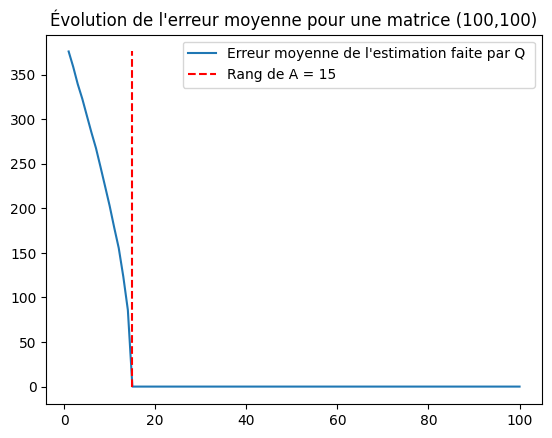

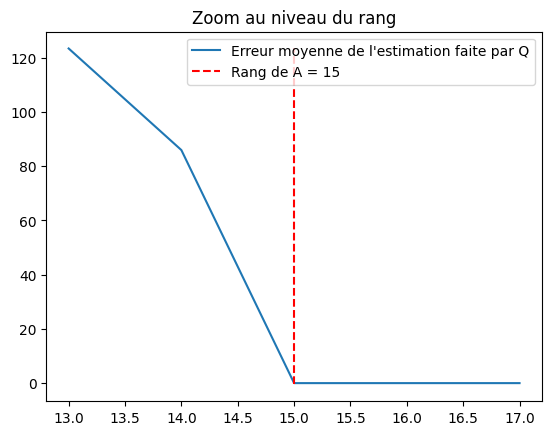

In [10]:
def courbe_evolution_erreur(A,nb_rep=100,overlap=3):
    n=np.shape(A)[1]
    L_x,L_y=[],[]
    for l in range(1,n+overlap):
        S=0
        L_x.append(l)
        for i in range(nb_rep):
            Y,Q,R=Randomized_range_finder(A,l)
            Q_etoile=etoile(Q)
            m,_=np.shape(Q)
            M=(np.identity(m)-Q@Q_etoile)@A
            S+=norme_2(M)
        L_y.append(S/nb_rep)
    return L_x,L_y

n=100
r=15
test= generate_low_rank_matrix(n, n, r) # on a une matrice aléatoire de rang au plus r
L_x,L_y=courbe_evolution_erreur(test,overlap=r//10)

plt.plot(L_x, L_y)
plt.plot([r, r], [-1, L_y[0]], '--r')  # ligne verticale au rang
plt.legend(["Erreur moyenne de l'estimation faite par Q ", f"Rang de A = {r}"])
plt.title("Évolution de l'erreur moyenne pour une matrice (100,100)")
plt.show()
plt.close()

plt.plot(L_x[r-3:r+2], L_y[r-3:r+2])
plt.plot([r, r], [-0.5, L_y[r-3]], '--r')  # ligne verticale au rang
plt.legend(["Erreur moyenne de l'estimation faite par Q", f"Rang de A = {r}"])
plt.title("Zoom au niveau du rang")

plt.show()
plt.close()


Rang de la matrice: 10


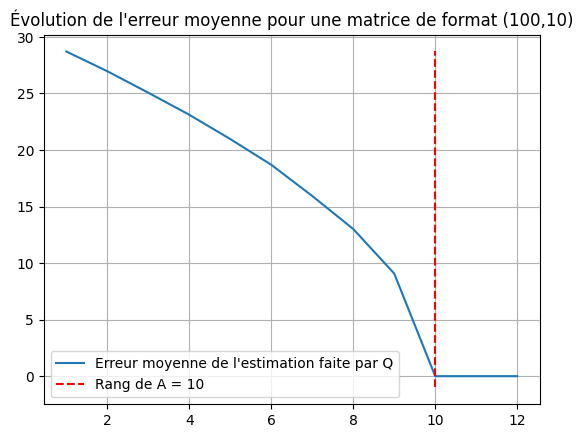

In [11]:
n=10
m=100
test_D= gaussian_random_matrix(n,m)
r=np.linalg.matrix_rank(test_D)
print("Rang de la matrice:", r)
L_x,L_y=courbe_evolution_erreur(test_D,overlap=5)


plt.plot(L_x[:r+2], L_y[:r+2])
plt.plot([r, r], [-1, L_y[0]], '--r')  # ligne verticale au rang
plt.legend(["Erreur moyenne de l'estimation faite par Q", f"Rang de A = {r}"])
plt.title("Évolution de l'erreur moyenne pour une matrice de format (100,10)")
plt.grid(True)

plt.show()


## Algortihme 5.1 et 5.3
Calcul d'une approximation d'une SVD de A à partir d'une matrice Q tels que QQ*A ≃ A
Application pour la diagonalisation

In [14]:
#Direct SVD (Algo 5.1)
def SVD_direct(A,Q):
    B=etoile(Q)@A
    U_tilde, Sigma, V_etoile = np.linalg.svd(B)
    U=Q@U_tilde
    return U,Sigma,V_etoile
#Decomposition DZ (Algo 5.3)
def DZ(A,Q):
    """A doit être hermitienne ie A*=A"""
    B=etoile(Q)@A@Q

    #On DZ B
    valeurs_propres, vecteurs_propres = np.linalg.eig(B)
    D = np.diag(valeurs_propres)
    V = vecteurs_propres
    U=Q@V
    return U,D

def DZ_spectre(A,Q):
    """A doit être hermitienne ie A*=A"""
    B=etoile(Q)@A@Q

    #On DZ B
    valeurs_propres, vecteurs_propres = np.linalg.eig(B)
    return valeurs_propres

### On va comparer le vrai spectre avec le spectre estimé

In [15]:
def distance_ensemble_opt(X, Y):
    """
    Calcule la distance minimale entre deux ensembles X et Y
    (réels ou complexes), c'est-à-dire
    min_sigma sum_i |x_i - y_sigma(i)|

    Utilise l'algorithme hongrois pour trouver la permutation optimale.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    n,m=len(X),len(Y)
    if len(X) != len(Y):
        raise ValueError("Les ensembles doivent avoir la même taille.")
    # Construction de la matrice de coûts : C[i,j] = distance entre x_i et y_j
    C = np.array( [[ np.abs(X[i]-Y[j]) for i in range(n) ] for j in range(m)])
    # Algorithme hongrois pour résoudre le problème d'affectation
    row_ind, col_ind = linear_sum_assignment(C)
    # Somme minimale des distances
    min_distance = C[row_ind, col_ind].sum()
    return min_distance

Rang de la matrice: 15


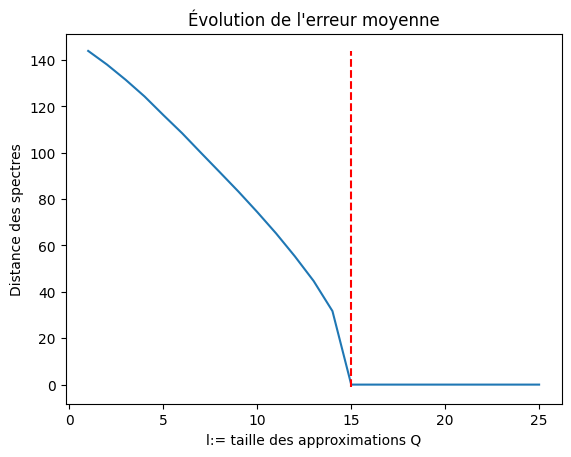

In [16]:
def courbe_evolution_erreur_spectre(A,nb_rep=100):
    n=np.shape(A)[1]
    valeurs_propres, _ = np.linalg.eig(A)
    L_x,L_y=[],[]
    for l in range(1,n+1):
        S=0
        L_x.append(l)
        for i in range(nb_rep):
            _,Q,_=Randomized_range_finder(A,l)
            valeurs_propres_approx=DZ_spectre(A,Q)
            valeurs_propres_approx=np.concatenate([valeurs_propres_approx, np.zeros(n - len(valeurs_propres_approx) )])
            S+=distance_ensemble_opt(valeurs_propres,valeurs_propres_approx)
        L_y.append(S/nb_rep)
    return L_x,L_y

n=25
r=15
test= generate_low_rank_matrix(n, n, r) # on a une matrice aléatoire de rang au plus r

valeurs_propres, _ = np.linalg.eig(test)

r=np.linalg.matrix_rank(test)
print("Rang de la matrice:", r)
L_x,L_y=courbe_evolution_erreur_spectre(test,nb_rep=1000)


plt.plot(L_x, L_y)
plt.plot([r, r], [-1, L_y[0]], '--r')  # ligne verticale au rang
plt.title("Évolution de l'erreur moyenne")
plt.xlabel("l:= taille des approximations Q")
plt.ylabel('Distance des spectres')
plt.show()


## Application au cas de matrice particulières

### 1 valeurs propres non nuls

In [18]:
def generation_vp_fixe_bas_rang(n,r,v):
    """Génère une matrice de taille n x n de rang = r et de spectre {0,v}.    """
    # On veut une matrice M tels qu'il existe P inversible tq P-1DP=M avec D=(v,...,v,0,...,0)
    D=[]
    for k in range(n):
        if k<r:
            D.append([v if i==k else 0 for i in range(n)])
        else:
            D.append([ 0 for i in range(n)])
    D=np.array(D)

    while True:
        P=gaussian_random_matrix(n,n)
        det = np.linalg.det(P)
        if det!=0: #Arrive souvent en pratique
            P_inv = np.linalg.inv(P)
            return (P@D)@ P_inv


In [ ]:
n=7
r=5
v=10**3 #v choisis "grands"
test= generation_vp_fixe_bas_rang(n,r,v)

r=np.linalg.matrix_rank(test)
print("Rang de la matrice:", r)
L_x,L_y=courbe_evolution_erreur_spectre(test,nb_rep=1000*10)
L_x=np.array(L_x)

m,p=np.polyfit(L_x[:r],L_y[:r],1)
print(m,p)


plt.plot(L_x, L_y)
plt.plot(L_x, L_y,'*')
plt.plot([r, r], [-1, L_y[0]], '--r')  # ligne verticale au rang

plt.title("Évolution de l'erreur moyenne")
plt.xlabel("l:= taille des approximations Q")
plt.ylabel("Distance des spectres")
plt.legend(["Rang 5 et spectre {0,10^3}"])
plt.show()
plt.close()

A=L_x[:r]*m+p-L_y[:r]
plt.plot([r, r], [-min(1,max(A)), max(A)], '--r')  # ligne verticale au rang

plt.plot(L_x[:r],A)

plt.title("Ecart entre la régression linéaire et la fonction")
plt.xlabel("l:= taille des approximations Q")
plt.ylabel('Distance des spectres')
plt.legend([f"Régression linéaire  y = {m:.2f}x + {p:.2f}"])
plt.show()



### 2 valeurs propres

In [19]:
def generation_2vp_bas_rang(n,r1,v1,r2,v2):
    """Génère une matrice de taille n x n de rang = r et de spectre {0,v1,v2}.    """
    # On veut une matrice M tels qu'il existe P inversible tq P-1DP=M avec D=(v,...,v,0,...,0)
    D=[]
    for k in range(n):
        if k<r1:
            D.append([v1 if i==k else 0 for i in range(n)])
        elif k<r1+r2:
            D.append([v2 if i==k else 0 for i in range(n)])
        else:
            D.append([ 0 for i in range(n)])
    D=np.array(D)
    while True:
        P=gaussian_random_matrix(n,n)
        det = np.linalg.det(P)
        if det!=0: #Arrive souvent en pratique
            P_inv = np.linalg.inv(P)
            return (P@D)@ P_inv


In [ ]:
n=10
r1,r2=4,4
v1,v2=2*10**3,10**2 #v choisis "grands"
test= generation_2vp_bas_rang(n,r1,v1,r2,v2)
r=r1+r2

valeurs_propres, _ = np.linalg.eig(test)
print("Valeurs propres de la matrice :")
print(valeurs_propres)
r=np.linalg.matrix_rank(test)
print("Rang de la matrice:", r)
L_x,L_y=courbe_evolution_erreur_spectre(test,nb_rep=1000)
L_x=np.array(L_x)



plt.plot(L_x[:r1], L_y[:r1])
plt.plot(L_x[r1:r], L_y[r1:r])
plt.plot(L_x[r-1:], L_y[r-1:])

plt.plot(L_x, L_y,'*')

plt.plot([r, r], [-1, L_y[0]], '--r')  # ligne verticale au rang
plt.title("Évolution de l'erreur moyenne")
plt.xlabel("l:= taille des approximations Q")
plt.ylabel('Distance des spectres')
plt.legend(["Spectre :{0,2.10^3,10^2}"])
plt.show()
plt.close()

#Interpoler sur les 2 segments et dire 3 régimes: les vp v1; puis les vp v2; puis les vp 0"""